In [1]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression
import sklearn
#from PyIF import te_compute as te
#from neuralprophet import NeuralProphet


In [2]:
'''
Functions for loading in and combining data
'''
def load_df(file_name, sheet = 'Sheet 1'):
    '''
    Load a file into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name=sheet)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    df = df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def yearly_to_quarterly(df):
    '''
    Inputs: df
    Converts the data from yearly to quarterly
    Outputs: quarterly_df
    '''
    data = df.to_numpy(dtype=np.float64)
    data = np.repeat(data, 4, axis = 1)
    quarterly_df = pd.DataFrame(data)
    quarterly_df.index = df.index
    quarterly_df.columns = GDP_df.columns[(int(df.columns[0]) - 1975)*4:(int(df.columns[-1]) - 2021)*4]
    return quarterly_df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs

def to_datetime(df):
    df.columns = [w.replace('-Q1','-01') for w in df.columns]
    df.columns = [w.replace('-Q2','-04') for w in df.columns]
    df.columns = [w.replace('-Q3', '-07') for w in df.columns]
    df.columns = [w.replace('-Q4', '-10') for w in df.columns]
    for i in df.columns[:]:
        i = np.datetime64(i)
    df.columns = pd.to_datetime(df.columns)
    return df

def extend_df(dfs):
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.union(set(i.index))
        cols = cols.union(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].reindex(index=idx, columns=cols)
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
        dfs[i] = to_datetime(dfs[i])
        dfs[i].interpolate(method='polynomial', order = 5, inplace = True, limit = 100, limit_direction = 'both', axis = 1)
        dfs[i].fillna(0)
    return dfs


In [3]:
'''
Functions for RNN time series prediction
'''
def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    X_norm = np.zeros(X.shape)
    y_norm = np.zeros(y.shape)
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X_norm[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y_norm[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5 
    return X_norm, X_attrs, y_norm, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0]
    return y_pred, history


In [4]:
'''
Regression stuff
'''

def run_regr(X, y, t, regr, colours):
    regr.fit(X, y)
    nrows = X.shape[0]
    y_reg = np.zeros(nrows)  
    for i in range(nrows):
        y_reg[i] = regr.predict(np.array([X[i, :]]))
    total_loss, loss = cal_loss(y, y_reg, nrows)
    plt.plot(t, y, colours[0], t, y_reg, colours[1])    
    return regr, total_loss, loss

def cal_loss(y, y_reg, nrows):
    abs_loss, per_loss = np.zeros(nrows), np.zeros(nrows)
    for i in range(nrows):
        abs_loss[i] = np.abs(y[i] - y_reg[i])
        if y[i] > 0:
            per_loss[i] = abs_loss[i] / y[i]
    total_loss, loss = np.sum(abs_loss)/ nrows, np.sum(per_loss)/ nrows
    return total_loss, loss

In [5]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('./data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('./data/hours_worked.xlsx')
employees_df = load_df('./data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)

#per_HW_df.iloc[4, :].T.plot(legend = False)

In [6]:
'''
Depression data
'''
dep_df = pd.read_csv('data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_quarterly_df = yearly_to_quarterly(dep_df)

'''
Education data
'''
education_dfs = [None] * 4
for i in range(4):
    education_dfs[i] = load_df('./data/Education.xlsx', 'Sheet ' + str(4*i + 1))
    education_dfs[i] = yearly_to_quarterly(education_dfs[i])
    education_dfs[i] = education_dfs[i].rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    

'''
Inflation data
'''
inf_df = pd.read_csv('data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']
inf_df = inf_df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Unemployment data
'''
unem_df = pd.read_csv('./data/unem.csv')
unem_df.fillna(0)
unem_df = unem_df[['LOCATION', 'TIME', 'Value']]
unem_df = unem_df.pivot_table('Value',  ['LOCATION'],'TIME')
unem_df = country_code_to_name(unem_df)



In [7]:
'''
Combine all dataframes and create a numpy array of the data
Data = [Country, Time, Feature]
'''
dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
matched_dfs = match_df(dfs)
data = np.zeros((len(matched_dfs[0].index), len(matched_dfs[0].columns),  len(matched_dfs)))
for i in range(len(matched_dfs)):
    data[:, :, i] = matched_dfs[i].to_numpy(dtype=np.float64)
matched_dfs[1]


,2008-Q1,2008-Q2,2008-Q3,2008-Q4,2009-Q1,2009-Q2,2009-Q3,2009-Q4,2010-Q1,2010-Q2,...,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4,2019-Q1,2019-Q2,2019-Q3,2019-Q4
TIME,,,,,,,,,,,,,,,,,,,,,
Austria,537.344956,563.244566,549.679923,574.753142,535.440455,548.677465,546.810112,583.284671,546.040840,568.177707,...,672.690971,715.115782,694.143873,694.903274,680.283683,735.279678,707.077815,712.706775,706.655983,745.302950
Belgium,611.402642,650.509000,611.189001,643.449734,609.283943,621.255617,609.988497,665.392445,616.821551,653.559524,...,724.471995,776.858710,733.940529,771.538079,727.325605,805.079956,759.323215,781.186857,751.422297,826.953821
Estonia,171.701788,190.377468,182.534316,178.910157,164.867715,176.504979,169.971297,183.658263,175.466804,191.819752,...,277.589863,293.317933,280.032487,304.915130,304.432135,320.218225,304.280370,330.497382,328.107378,339.227333
Finland,579.350013,586.306544,570.942422,621.474505,562.710294,566.491187,561.264723,623.490623,577.384773,591.012423,...,705.820527,760.885977,722.630770,722.863192,706.791371,772.158035,735.496109,744.788131,724.574777,796.554815
France,568.928419,571.953573,549.212748,573.509524,554.414509,556.772397,541.990617,584.201462,569.643620,578.276966,...,641.580188,676.407961,667.970758,666.923682,652.423829,694.526800,685.086642,688.967836,676.998156,706.971493
Germany,533.261691,537.787264,526.458031,525.027097,498.587068,498.165814,516.895246,521.901949,526.844000,530.364765,...,633.870803,652.256611,640.571441,651.784794,648.846794,663.996149,656.987494,662.946576,670.291155,670.776516
Greece,450.237773,475.350999,493.613691,494.032784,431.791418,479.375864,484.782423,510.227724,454.466483,467.887041,...,445.081227,435.830798,404.962170,418.280658,438.439335,426.930667,393.208134,412.272885,439.291495,417.200137
Ireland,730.837838,712.962459,709.483959,717.768395,729.491893,737.183130,730.276180,725.745522,751.570211,748.128309,...,1142.165178,1194.916464,1185.451518,1136.597987,1210.725858,1198.363725,1223.917587,1195.186922,1296.389764,1293.331757
Italy,614.724780,633.805433,602.236385,651.236052,585.712091,607.700298,600.325440,655.454294,601.425367,636.596891,...,651.496704,706.558201,653.060782,663.700334,656.601482,718.317815,658.660202,671.429938,668.084421,722.759252


"\nExtended data is sparse so doesn't work well\ndata = np.zeros((len(extended_dfs[0].index), len(extended_dfs[0].columns),  len(extended_dfs)))\nfor i in range(len(extended_dfs)):\n    data[:, :, i] = extended_dfs[i].to_numpy(dtype=np.float64)\ndata = np.nan_to_num(data, copy=True, nan=0.0)\n"

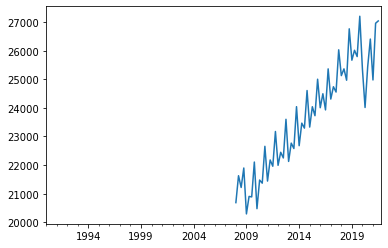

In [8]:
dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
extended_dfs = extend_df(dfs)
extended_dfs[0].iloc[1, :].plot()

'''
Extended data is sparse so doesn't work well
data = np.zeros((len(extended_dfs[0].index), len(extended_dfs[0].columns),  len(extended_dfs)))
for i in range(len(extended_dfs)):
    data[:, :, i] = extended_dfs[i].to_numpy(dtype=np.float64)
data = np.nan_to_num(data, copy=True, nan=0.0)
'''


<AxesSubplot:>

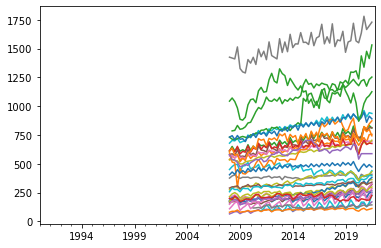

In [9]:
extended_dfs[1].iloc[:, :].T.plot(legend = False)

In [19]:
from sklearn.ensemble import RandomForestRegressor

286.301165851894 0.01236397461405627


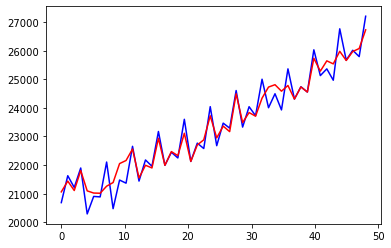

In [20]:
X = data[0, :, 2:]
y = data[0, :, 0]
t = np.linspace(0, y.shape[0], y.shape[0])

regr, total_loss, loss = run_regr(X, y, t, RandomForestRegressor(n_estimators=5), ['b', 'r'])
print(total_loss, loss)


651.8114239446159 0.026699745728595476
714.7055245615585 0.03238208634339688
349.0998400834623 0.014640469905713627
775.0715255441556 0.03511674106102993
498.07699863143034 0.021521681219567462
551.6296279964948 0.02345890933083727
310.4509652221632 0.013359257522310148


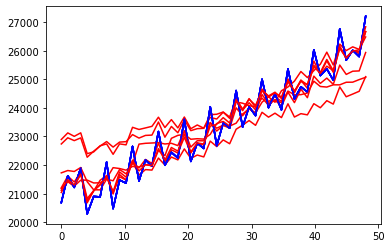

In [12]:
'''
Attempting to vary values in regression to assess impact on productivity
'''
for i in range(X.shape[1]):
    X = data[0, :, 2:]
    y = data[0, :, 0]
    regr = RandomForestRegressor()
    regr.fit(X, y)
    X[:, i] = X[:, i] *2
    y_pred = regr.predict(X)
    t = np.linspace(0, y.shape[0], y.shape[0])
    total_loss, abs_loss = cal_loss(y, y_pred, t.size)
    print(total_loss, abs_loss)
    plt.plot(t, y, 'b', t, y_pred, 'r')

In [13]:
'''
Making a dataframe in Neural Prophet format
'''
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)
per_HW_df = to_datetime(per_HW_df)
per_HW_df = per_HW_df.T
per_HW_df.reset_index(inplace=True)
belgium_df = per_HW_df[['index', 'Belgium']].copy()
belgium_df.columns = ['ds', 'y']
belgium_df['ds'] = pd.to_datetime(belgium_df['ds'])
train_df = belgium_df.head(45)
test_df = belgium_df.tail(10)

In [14]:
'''
Attemping to predict the future with Neural Prophet
'''

'''
m = NeuralProphet()
m.fit(train_df)
'''

'\nm = NeuralProphet()\nm.fit(train_df)\n'

In [15]:
'''
Transfer Entropy
Requires numpy 1.21 or less
'''
X = data[1, :, 8]
y = data[1, :, 0]
#te.te_compute(X, y, k=1, embedding=1, safetyCheck=True, GPU=False)

In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, random_state=0)


C:\Users\crisp\anaconda3\envs\ads\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


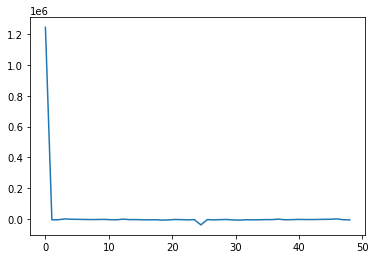

In [17]:
'''
Fourier transform and frequency analysis
'''
y_freq = np.fft.fft(y)
t_freq = np.linspace(0, y.shape[0], y.shape[0])
plt.plot(t_freq, y_freq)

In [18]:
'''
Mutual information, F-statistic and R-statistic between features and target
'''
X = data[1, :, 1:]
y = data[1, :, 0]
mi = mutual_info_regression(X, y)
mi /= np.max(mi)
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)
corr = r_regression(X, y)
corr /= np.max(corr)



mi, f_test, corr

(array([1.        , 0.31934416, 0.29766122, 0.17971594, 0.2611854 ,
        0.10606819, 0.03345203, 0.17671715]),
 array([1.00000000e+00, 2.13027660e-02, 2.13027660e-02, 2.82153940e-03,
        1.63964235e-02, 2.13257891e-04, 7.78999339e-04, 8.80763774e-03]),
 array([ 1.        , -0.90815698,  0.90815698,  0.61608728,  0.8847625 ,
        -0.20996431, -0.37979531, -0.81097251]))

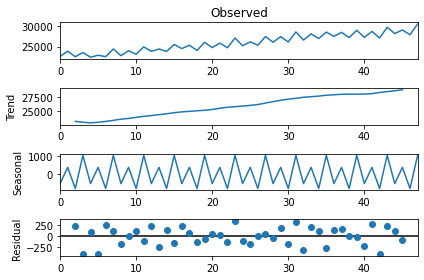

In [19]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=4)
fig = decomposition.plot()

117.81439972138577 0.00472189666666462


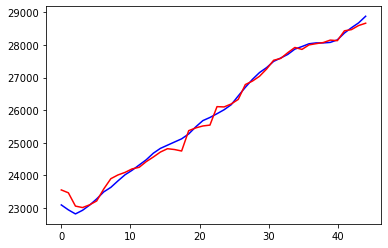

In [20]:
X = data[1, 2:-2, 6:10]
y = decomposition.trend[2:-2]
t = np.linspace(0, y.shape[0], y.shape[0])

regr, total_loss, loss = run_regr(X, y, t, RandomForestRegressor(), ['b', 'r'])
print(total_loss, loss)


317.0906035521378 0.23147709178172227


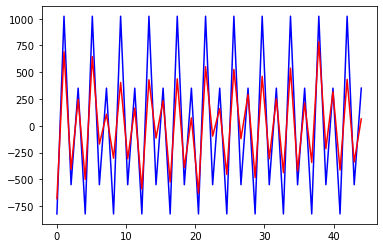

In [21]:
X = data[1, 2:-2, 6:10]
y = decomposition.seasonal[2:-2]
t = np.linspace(0, y.shape[0], y.shape[0])

regr, total_loss, loss = run_regr(X, y, t, RandomForestRegressor(), ['b', 'r'])
print(total_loss, loss)

C:\Users\crisp\anaconda3\envs\ads\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


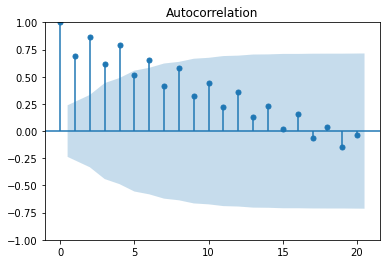

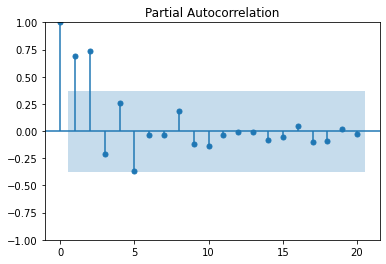

<Figure size 432x288 with 0 Axes>

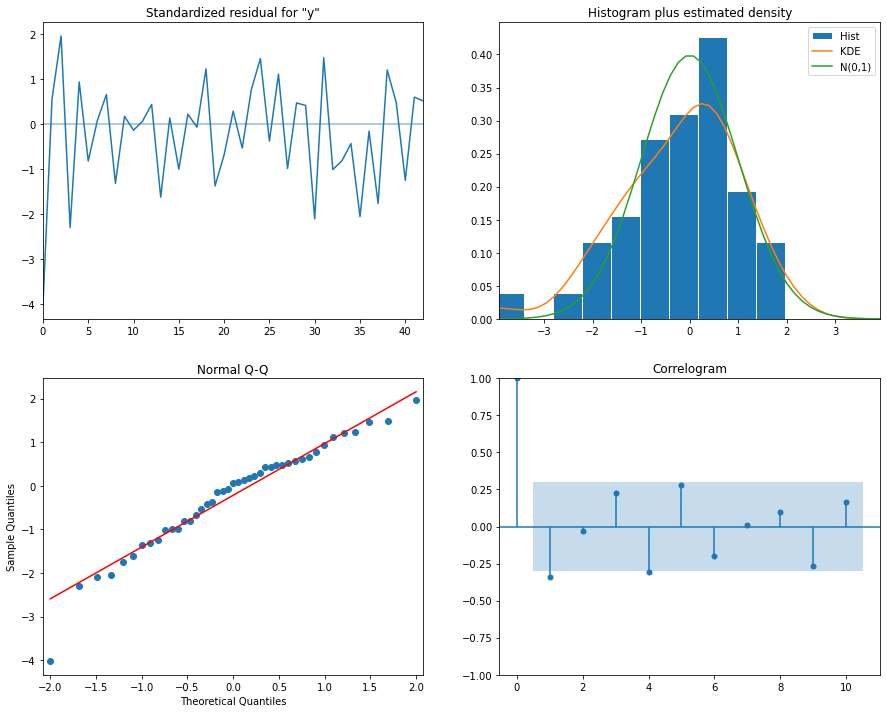

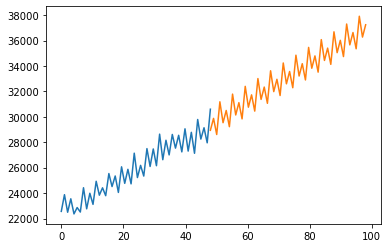

In [22]:
y = data[1, :, 0]
t = np.linspace(0, y.shape[0], y.shape[0])
plot_acf(y, lags=20, alpha = 0.1)
plot_pacf(y, lags=20, alpha = 0.01, method='ywm')
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order = (1, 1, 1, 4))
res = model.fit()
plt.figure()
res.plot_diagnostics(figsize=(15, 12))
forecast_values = res.get_forecast(steps=50)
plt.figure()
ax = plt.plot(t, y, np.linspace(t[-1], t[-1] + 50, 50), forecast_values.predicted_mean)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (38, 16)                  1200      
_________________________________________________________________
dense_1 (Dense)              (38, 2)                   34        
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
9/9 [==============================] - 3s 67ms/step - loss: 0.5449 - mean_squared_error: 0.5449 - val_loss: 1.1192 - val_mean_squared_error: 1.1192
Epoch 2/40
9/9 [==============================] - 0s 10ms/step - loss: 0.3323 - mean_squared_error: 0.3323 - val_loss: 0.6939 - val_mean_squared_error: 0.6939
Epoch 3/40
9/9 [==============================] - 0s 11ms/step - loss: 0.2190 - mean_squared_error: 0.2190 - val_loss: 0.4375 - val_mean_squared_error: 0.4375
Epoch 4/40
9/9 [=======================

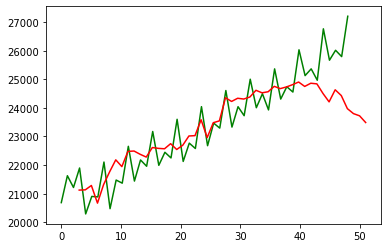

In [24]:
'''
RNN on the data
'''
time_step, data_memory, epochs, batch_size, split_point = 5, 8, 40, 4, 0.8

load_model_bool, load_model, save_model, save_fig = False, 'EU_model', 'EU_model', 'EU'
model_layer = [layers.GRU(16,activation= 'tanh', dropout = 0.1, recurrent_dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
print_summary = True
X = data[0, :, 2:]
y = data[0, :, 0:1]
t = np.linspace(0, y.shape[0], y.shape[0])
y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)

plt.plot(t, y, 'g', t + time_step - 2, y_pred[:, 0], 'r')
train_loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
'''
RNN on the decomposed data
'''
time_step, data_memory, epochs, batch_size, split_point = 1, 8, 40, 4, 0.8

load_model_bool, load_model, save_model, save_fig = False, 'EU_model', 'EU_model', 'EU'
model_layer = [layers.Dense(8, activation= 'linear'),
                layers.LSTM(16,activation= 'tanh', dropout = 0.1, recurrent_dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
print_summary = True
X = data[0, :, 2:]

y = data[0, :, 0:1]
X = data[1, 2:-2, 2:]
y = np.array([decomposition.trend[2:-2]]).T
t = np.linspace(0, y.shape[0], y.shape[0])
y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)

plt.plot(t, y, 'g', t + time_step - 2, y_pred[:, 0], 'r')
train_loss = history.history['loss']
val_loss = history.history['val_loss']

y = np.array([decomposition.seasonal[2:-2]]).T
y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)
plt.plot(t, y, 'g', t + time_step - 2, y_pred[:, 0], 'r')

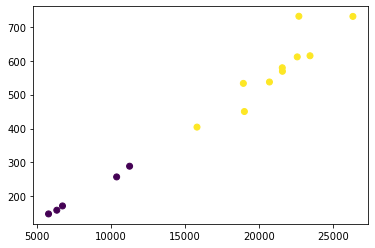

In [26]:
'''
Clustering of features using K-means

X = [Country, Time, Features]
Plot the clusters against properties
'''
X = data[:, 0, :]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
plt.scatter(X[:, 0], X[:, 1], c= kmeans.labels_)

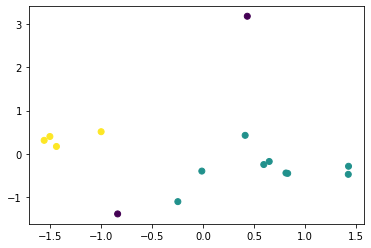

In [27]:
'''
Clustering of features using DBSCAN
'''
X = data[:, 0, :]
y = data[:, 1, :]
X, X_attrs, y, y_attrs = normalise(X, y)
dbs = DBSCAN(eps = 2.5, min_samples= 2).fit(X)
plt.scatter(X[:, 1], X[:, 4], c= dbs.labels_)

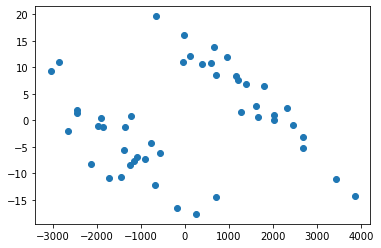

In [38]:
'''
PCA
'''
X = data[0, :, :]
pca = PCA()
pca = pca.fit_transform(X)
fig2 = plt.scatter(pca[:, 0], pca[:, 1])

C:\Users\crisp\anaconda3\envs\ads\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\crisp\anaconda3\envs\ads\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


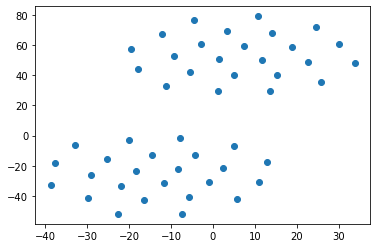

In [35]:
X = data[0, :, 2:]
y = data[0, :, 1]
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig2 = plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [30]:
# import model
from sklearn.linear_model import ElasticNet
# X = df.iloc[:, :7]
#output
# Y = gdp_df
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
print(Y)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.5, random_state=4)
'''
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, :7], gdp_df.iloc[:,-1],
    test_size = 0.25, random_state=5)'''
# Train the model
e_net = ElasticNet(alpha = 1)
e_net.fit(x_train, y_train)
x_train = pd.DataFrame(x_train)
# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(x_test)
mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
print("Mean Squared Error on test set", mean_squared_error)
e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = x_train.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_)
e_net_coeff

[537.34495582 563.24456638 549.67992305 574.75314208 535.44045521
 548.67746518 546.81011214 583.28467122 546.04084049 568.17770653
 563.80611801 600.96468587 570.2502147  588.31413948 582.48179255
 616.34252707 589.60196361 598.60583948 590.17733094 631.04007725
 596.44442444 612.03250567 606.97319473 653.32957902 619.62872788
 641.16139091 631.23013393 672.30634628 639.15013728 656.85267019
 646.50648026 684.99201818 661.30309573 672.91650726 652.01788114
 696.80082294 669.65347093 679.64730837 672.69097067 715.11578234
 694.14387349 694.90327436 680.28368325 735.27967815 707.07781483
 712.70677501 706.65598316 745.30294999]
Mean Squared Error on test set 386.5029111673812


,Columns,Coefficient Estimate
0,0,-5.136532
1,1,5.140605
2,2,1.247059
3,3,1.482997
4,4,2.744487
5,5,-2.489252
6,6,0.000000


In [31]:
# import ridge regression from sklearn library
from sklearn.linear_model import Ridge
# Y = gdp_df
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.5, random_state=4)

# Train the model
ridgeR = Ridge(alpha = 1)
ridgeR.fit(x_train, y_train)
y_pred = ridgeR.predict(x_test)

# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print(mean_squared_error_ridge)

x_train = pd.DataFrame(x_train)
# get ridge coefficient and print them
ridge_coefficient = pd.DataFrame()
ridge_coefficient["Columns"]= x_train.columns
ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_)
ridge_coefficient


389.47236206391517


,Columns,Coefficient Estimate
0,0,-8.443104
1,1,8.443104
2,2,-2.871254
3,3,-3.489473
4,4,3.161940
5,5,-3.961224
6,6,4.623487


In [32]:
# import Lasso regression from sklearn library
from sklearn.linear_model import Lasso

X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.5, random_state=4)

# Train the model
lasso = Lasso(alpha = 1)
lasso.fit(x_train, y_train)
y_pred1 = lasso.predict(x_test)

# Calculate Mean Squared Error
mean_squared_error = np.mean((y_pred1 - y_test)**2)
print("Mean squared error on test set", mean_squared_error)

x_train = pd.DataFrame(x_train)
lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = x_train.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)

lasso_coeff


Mean squared error on test set 384.90768918271056


,Columns,Coefficient Estimate
0,0,-1.269224e+01
1,1,2.286301e-14
2,2,2.341394e-01
3,3,-0.000000e+00
4,4,3.010917e+00
5,5,-3.282023e+00
6,6,0.000000e+00
